Trello: https://trello.com/invite/b/3ohX9Zfw/ATTI0b0fc1882000cf7e5f057f6ad96f2d93D6EB336E/bobbibbub

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats
import itertools
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('Данные по использованию климатических систем.csv', sep=';')

In [3]:
# Найстройка графиков

params = {'text.color': "white", "font.size": 12}
plt.rcParams.update(params)
plt.tight_layout()
sns.set(style="whitegrid", font_scale=1.5)

<Figure size 640x480 with 0 Axes>

In [4]:
# PEP8

def make_word_pep8style(word: str) -> str:
    return word.lower().replace(' ', '_')

df = df.rename(make_word_pep8style, axis='columns')

list(df.columns)

['год',
 'время_года',
 'климат',
 'город',
 'страна',
 'способ_охлаждения',
 'режим_при_смешанном_типе_охлаждения',
 'способ_обогрева',
 'возраст',
 'пол',
 'ощущение_температуры',
 'ощущение_температуры_(bool)',
 'предпочтительное_изменение_температуры',
 'ощущение_движения_воздуха_(bool)',
 'предпочтительное_изменение_движения_воздуха',
 'оценка_комфорта',
 'утепление',
 'температура_воздуха_в_помещении',
 'температура_воздуха_на_улице',
 'rh',
 'скорость_воздуха',
 'рост',
 'вес',
 'занавески',
 'вентилятор',
 'окно',
 'двери',
 'отопление',
 'среднемесячная_температура_на_улице',
 'количество_рекламаций']

# Исследование данных на качество и предобработка

Разделим данные на числовые и категориальные

In [5]:
numerical = [
    'возраст',
    'температура_воздуха_в_помещении',
    'температура_воздуха_на_улице',
    'rh',
    'скорость_воздуха',
    'рост',
    'вес',
    'среднемесячная_температура_на_улице',
    'количество_рекламаций',
    'утепление',
    'ощущение_температуры',
    'оценка_комфорта',
]
categorial = list(set(df.columns) ^ set(numerical))

categorial_bool = [
    'ощущение_температуры_(bool)',
    'занавески',
    'вентилятор',
    'окно',
    'двери',
    'отопление'
]

## Первичный графический анализ

Для поиска аномалий, выбросов используем графический метод: в категориальных факторах используем круговую диаграмму, а в количественных гистограммы и ящик с усами (boxplot)

### Для каждого числового столбца построим гистограмму и ящик с усами

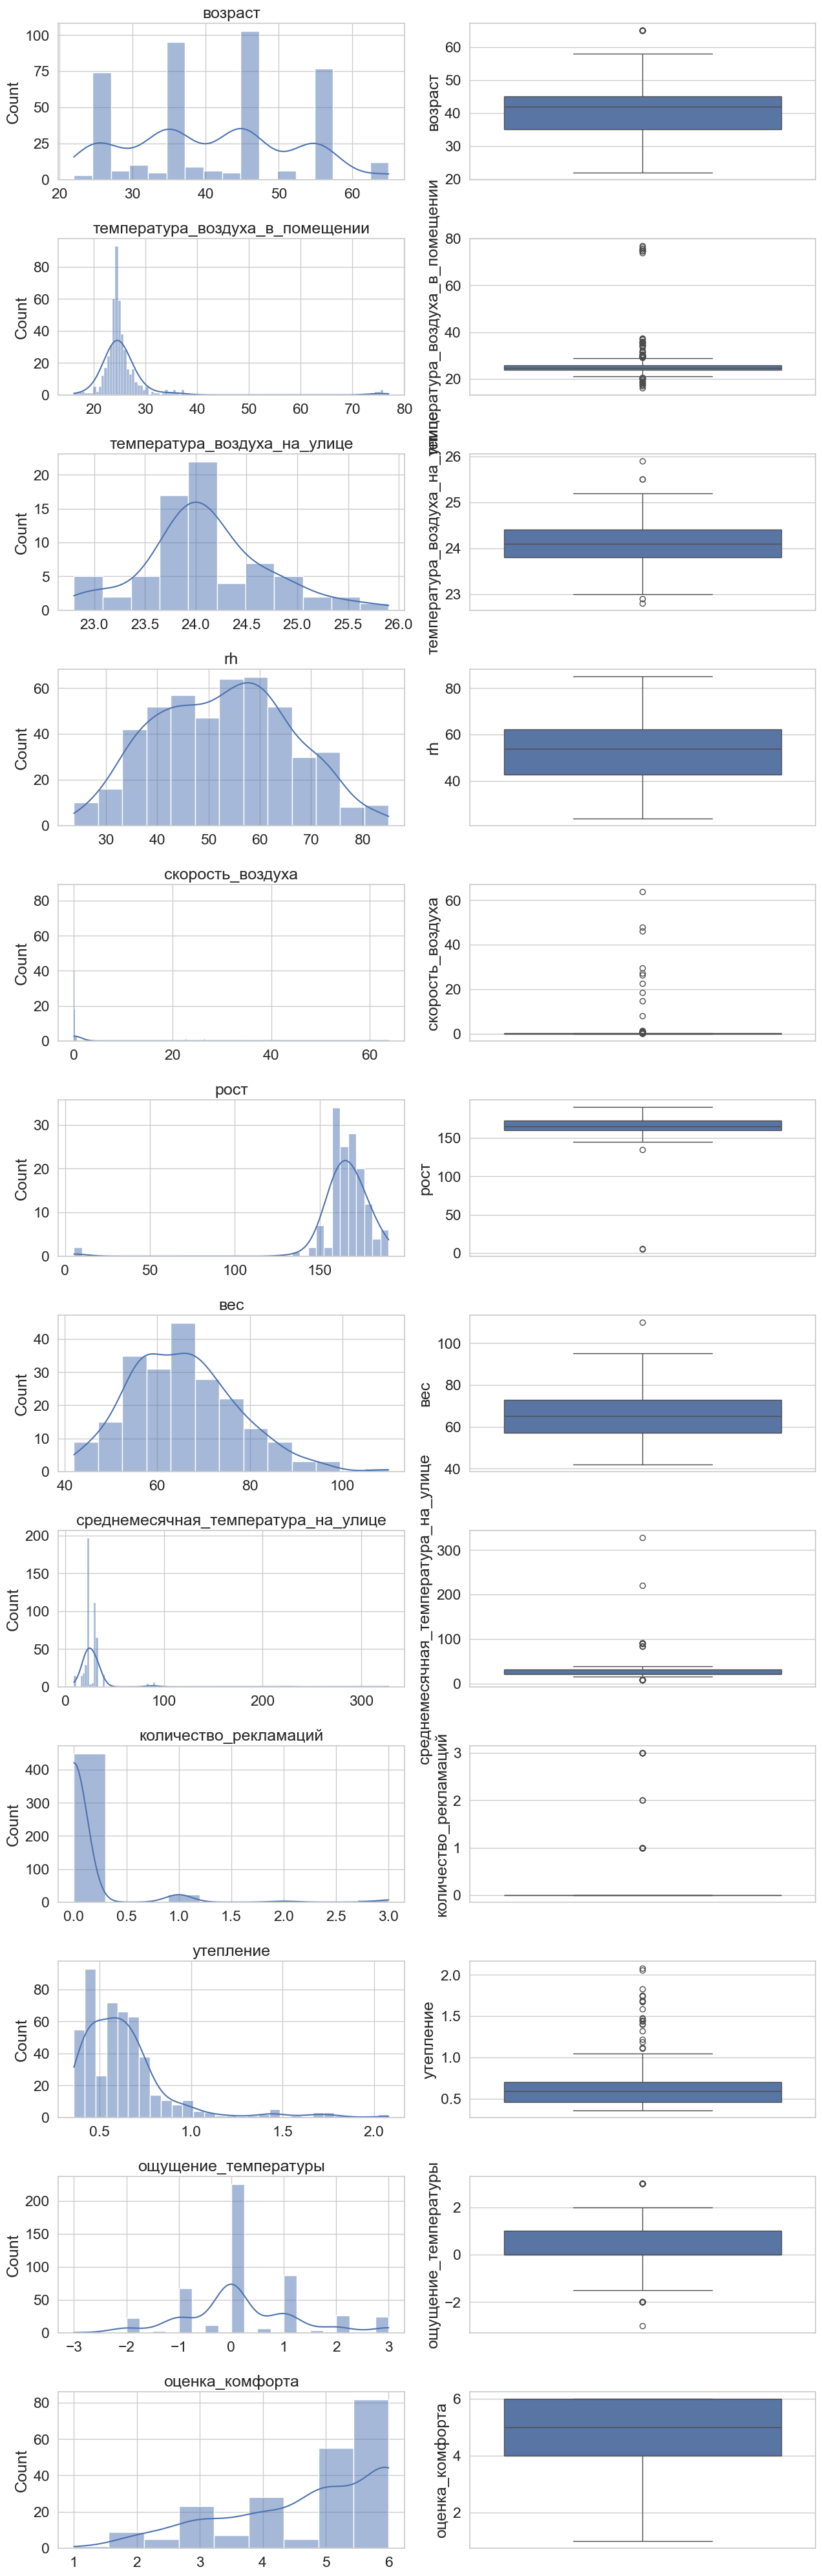

In [6]:
fig, ax = plt.subplots(len(numerical), 2)
fig.set_figheight(40)
fig.set_figwidth(13)
fig.tight_layout(h_pad=2)

for i, col in enumerate(numerical):
    sns.histplot(df[col], kde=True, ax=ax[i][0])
    sns.boxplot(df[col], ax=ax[i][1])
    ax[i][0].set_xlabel("")
    ax[i][0].set_title(col)

А для каждого категориального столбца построим круговую диаграму

C:\Users\Арсений\AppData\Local\Temp\ipykernel_19440\1804208781.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  value_counts = pd.value_counts(df[col], dropna=False)
C:\Users\Арсений\AppData\Local\Temp\ipykernel_19440\1804208781.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  value_counts = pd.value_counts(df[col], dropna=False)
C:\Users\Арсений\AppData\Local\Temp\ipykernel_19440\1804208781.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  value_counts = pd.value_counts(df[col], dropna=False)
C:\Users\Арсений\AppData\Local\Temp\ipykernel_19440\1804208781.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  value_counts = pd.valu

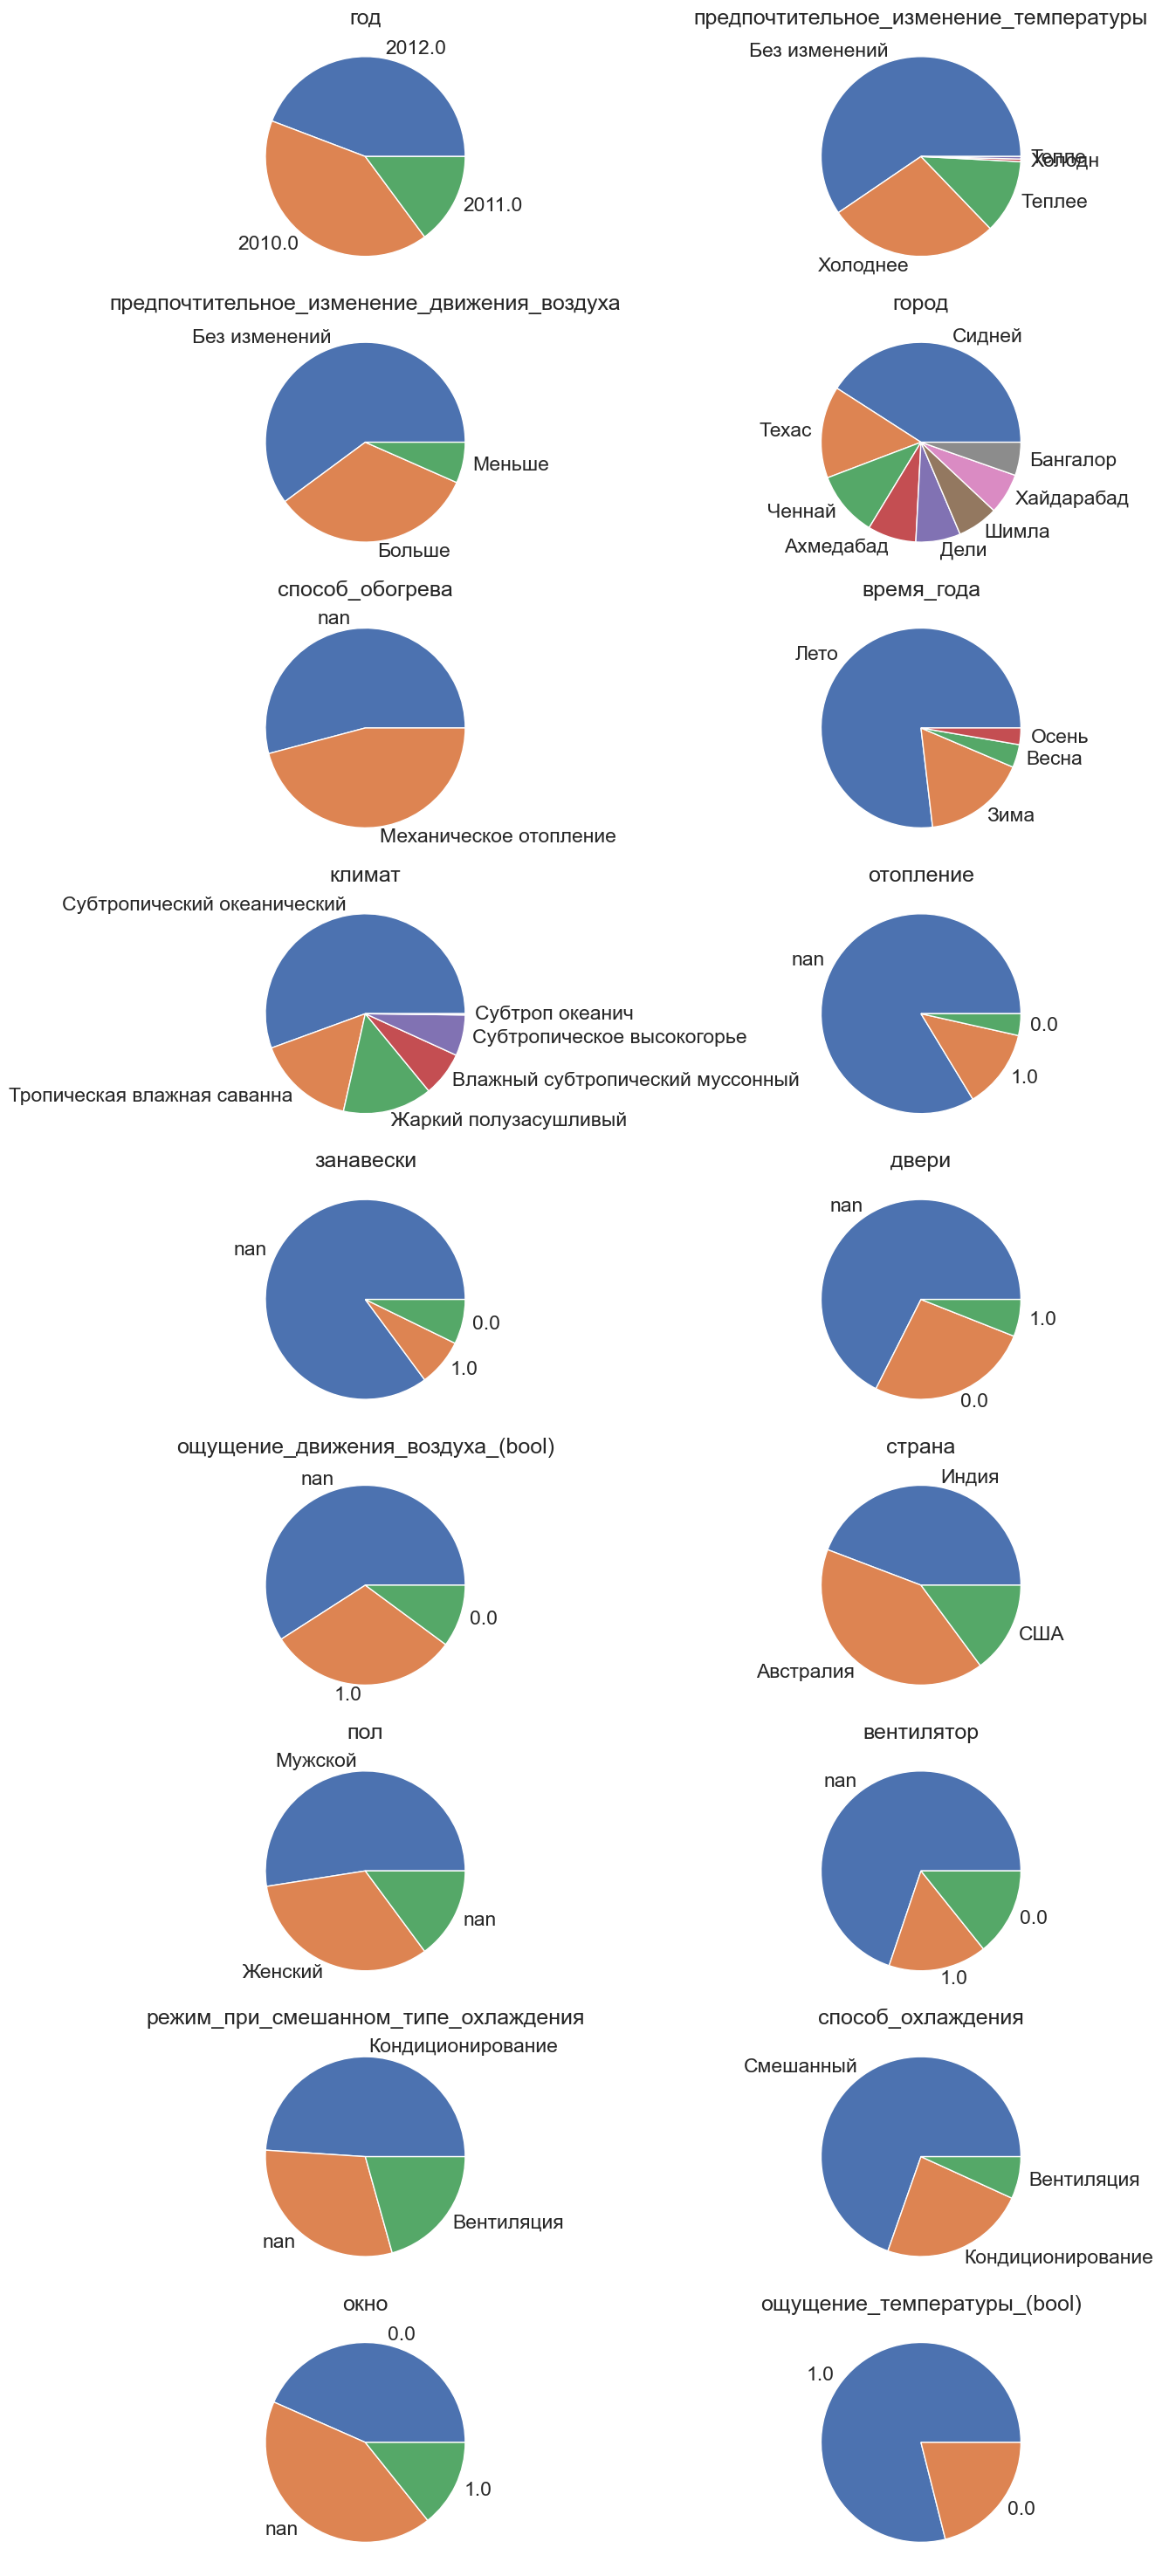

In [7]:
fig, ax = plt.subplots((len(categorial) + 1) // 2, 2)
fig.set_figheight(30)
fig.set_figwidth(13)
fig.tight_layout(h_pad=0)
for i, col in enumerate(categorial):
    value_counts = pd.value_counts(df[col], dropna=False)
    ax[i // 2][i % 2].pie(value_counts, labels=value_counts.index)
    ax[i // 2][i % 2].set_title(col)

Так как столбик *"режим_при_смешанном_типе_охлаждения"* и *"способ_охлаждения"* имеют одинаковый смысл, то можно заменить *"смешанный"* в *"режим_при_смешанном_типе_охлаждения"* на *"Кондиционирование"* или *"Вентиляция"*.

In [8]:
def change_kind_of_cooling(row):
    if row['режим_при_смешанном_типе_охлаждения'] == 'Кондиционирование':
        return 'Кондиционирование'
    elif row['режим_при_смешанном_типе_охлаждения'] == 'Вентиляция':
        return 'Вентиляция'
    return row['способ_охлаждения']

df['способ_охлаждения'] = df.apply(change_kind_of_cooling, axis='columns')
df = df.drop('режим_при_смешанном_типе_охлаждения', axis=1)
categorial.remove('режим_при_смешанном_типе_охлаждения')

## Исправление орфографических ошибок (task2)

Обнаружены орфографические ошибки:
- В столбце **"предпочтительное_изменение_температуры"** *"Тепле"* и *"Холодн"*
- В столбце **"климат"** *"Субтроп океанич"*
- *"Техас"* в столбце **"город"** это ошибка, однако заменить мы это ничем не можем, так как городов в штате Техас много, но и избавляться от этих дынных не стоит, поэтому оставим как есть

C:\Users\Арсений\AppData\Local\Temp\ipykernel_19440\712864138.py:19: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  value_counts = pd.value_counts(df[col], dropna=False)
C:\Users\Арсений\AppData\Local\Temp\ipykernel_19440\712864138.py:19: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  value_counts = pd.value_counts(df[col], dropna=False)


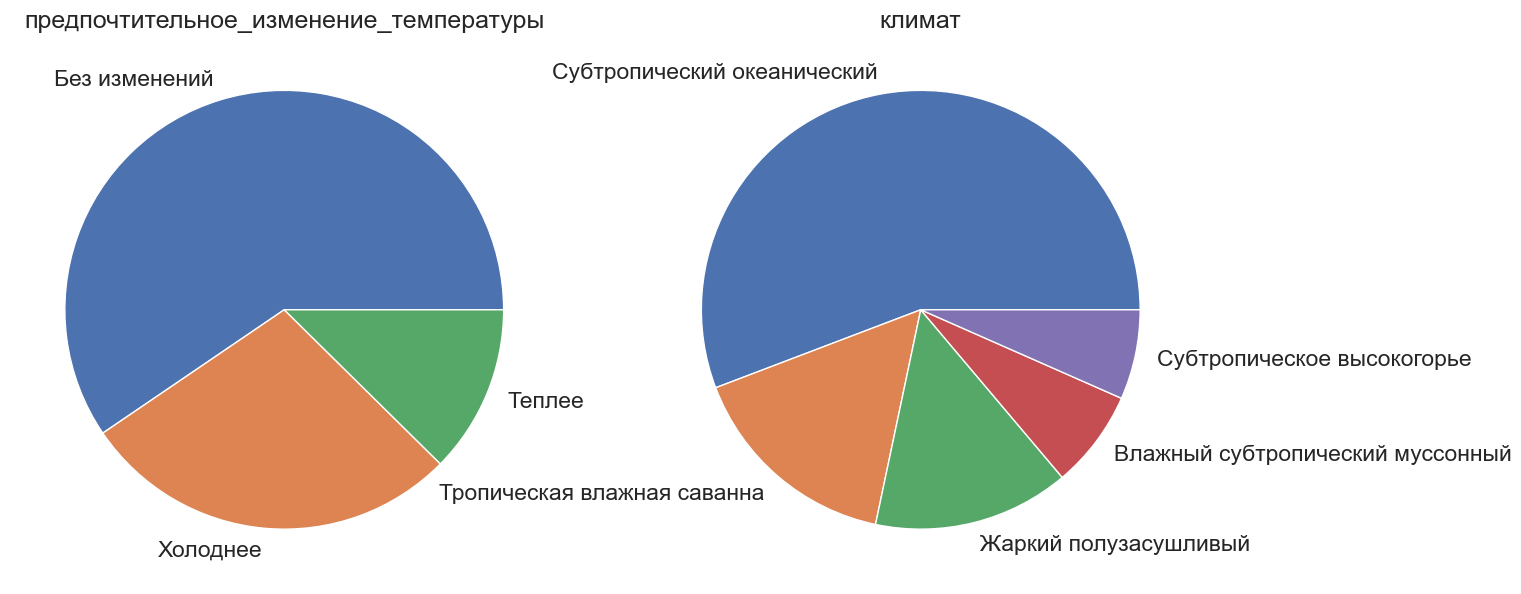

In [9]:
def fix_spelling_1st_problem(word: str) -> str:
    return "Теплее" if word == "Тепле" else "Холоднее" if word == "Холодн" else word
 
def fix_spelling_2nd_problem(word: str) -> str:
    return "Cубтропический океанический" if word == "Cубтроп океанич" else word

df["предпочтительное_изменение_температуры"] = df["предпочтительное_изменение_температуры"].apply(fix_spelling_1st_problem)
df["климат"] = df["климат"].apply(fix_spelling_2nd_problem)

# Проверка 

columns = ['предпочтительное_изменение_температуры', 'климат']

fig, ax = plt.subplots(1, 2)
fig.set_figheight(30)
fig.set_figwidth(13)
fig.tight_layout(h_pad=0)
for ind, col in enumerate(columns):
    value_counts = pd.value_counts(df[col], dropna=False)
    ax[ind].pie(value_counts, labels=value_counts.index)
    ax[ind].set_title(col)

## Исправление выбросов в росте (task5)

рост ~140 см считаем не аномалией

Text(0.5, 1.0, 'рост')

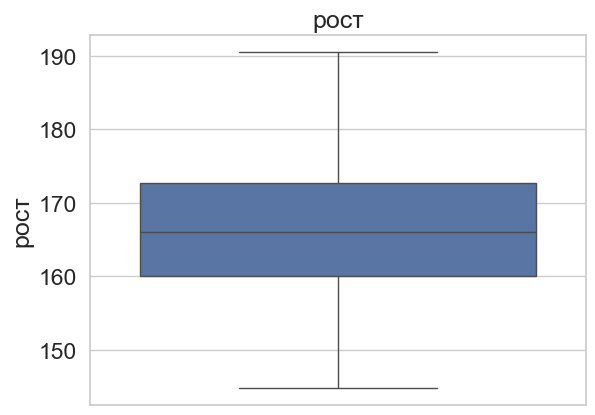

In [10]:
def fix_height(num: int) -> int:
    return None if num < 135 else num

df['рост'] = df['рост'].apply(fix_height)

fig, ax = plt.subplots()
sns.boxplot(df['рост'], ax=ax)
ax.set_title("рост")

## Исправление выбросов в скорости воздуха (task5)

скорость > 5 м/с **в помещении** считаем аномальной

<Axes: ylabel='скорость_воздуха'>

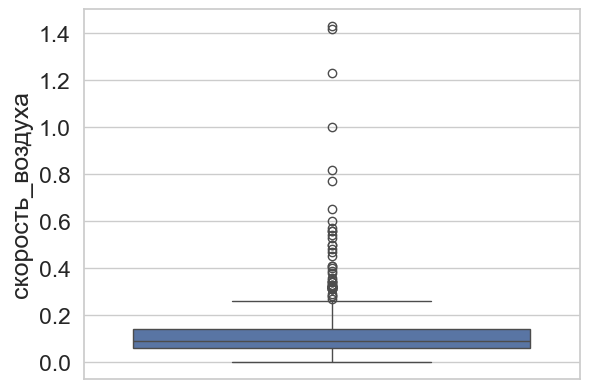

In [11]:
# заменяем все показания в колонке скорость воздуха больше 30 на None, ибо такие показатели аномальные
df['скорость_воздуха'] = df['скорость_воздуха'].apply(lambda x: None if x > 5 or x is None else x)

sns.boxplot(df['скорость_воздуха'])

## Исследование колонок с температурой (task5)

Исследуем аномалии используя boxplot

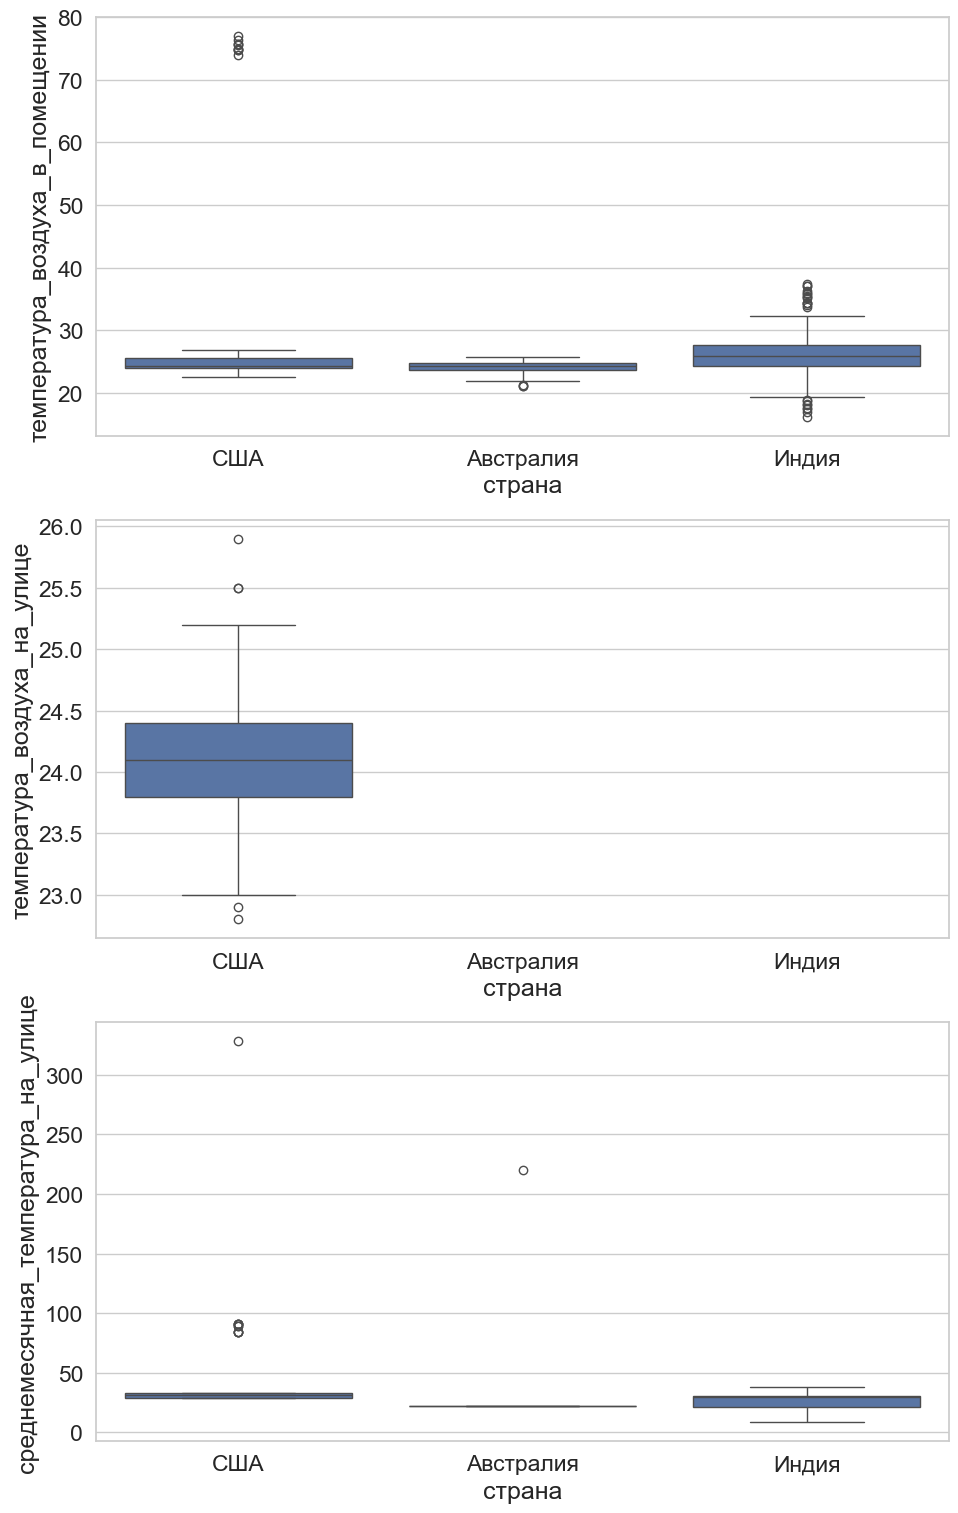

In [12]:
temperature_cols = [
    'температура_воздуха_в_помещении',
    'температура_воздуха_на_улице',
    'среднемесячная_температура_на_улице'
]
fig, ax = plt.subplots(3, 1)
fig.set_figwidth(11)
fig.set_figheight(18.5)
for i, col in enumerate(temperature_cols):
    sns.boxplot(data=df, x='страна', y=col, ax=ax[i])

Заметим, что у США наблюдаются выбросы в большую сторону. Предположим, что температура указана в °F. Тогда конвертируем все значения больше 40 из °F в °C. 

C:\Users\Арсений\AppData\Local\Temp\ipykernel_19440\3032604568.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[17] is None:
C:\Users\Арсений\AppData\Local\Temp\ipykernel_19440\3032604568.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[4] == 'США':
C:\Users\Арсений\AppData\Local\Temp\ipykernel_19440\3032604568.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[17] > 40:
C:\Users\Арсений\AppData\Local\Tem

<Axes: xlabel='страна', ylabel='температура_воздуха_в_помещении'>

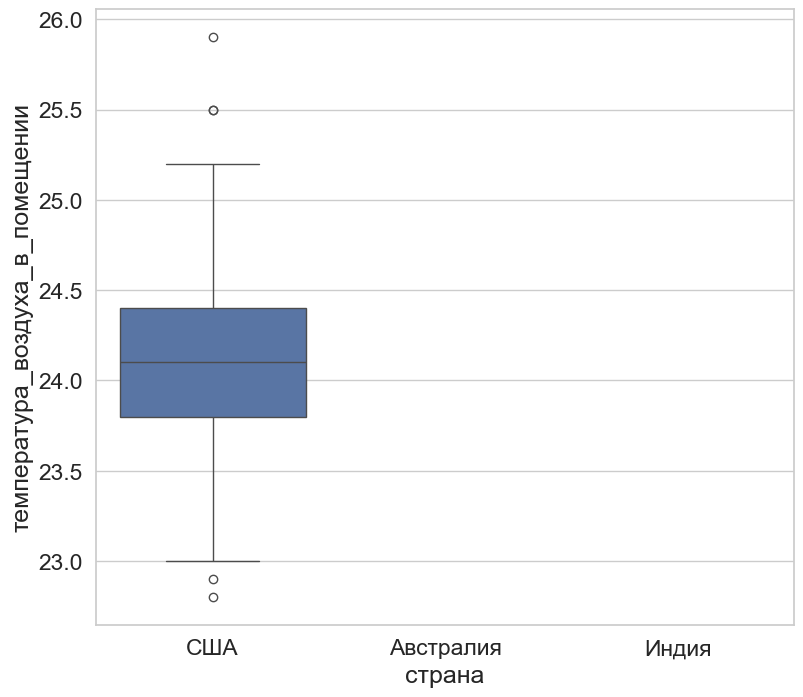

In [13]:
def f2c(row):
    if row[17] is None:
        return None
    
    if row[4] == 'США':
        if row[17] > 40:
            return row[17] * 5 / 9 - 32
    return row[17]

df_new = pd.DataFrame()
df_new['страна'] = df['страна']
df_new['время_года'] = df['время_года']
df_new['температура_воздуха_в_помещении'] = df.apply(f2c, axis=1)
# print(df_new[df_new['время_года'] == 'Лето'])
fig, ax = plt.subplots(1, 1)
fig.set_figheight(8)
fig.set_figwidth(9)
sns.boxplot(data=df_new[df_new['время_года'] == 'Лето'], x='страна', y='температура_воздуха_в_помещении', ax=ax)

Поскольку после приведения температуры из °F в °C, оказалось, что температура помещения в США летом составила в нижней квартили 12°C, поэтому гипотезу выше отвергаем. </br>Данных довольно мало в факторе **"температура в помещении"**, и нам придется по ним строить модель, поэтому попробуем все-таки использовать эти данные: там, где температура помещения в США больше 30, мы вычтем 50. То есть мы предпологаем, что в этих иземерниях была допущена ошибка и к температуре было добавлено константное число 50. </br>По такому же принципу исправим данные в **"среднемесячной температуре"** в США, поскольку там тоже наблюдаются выбросы в большую сторону.

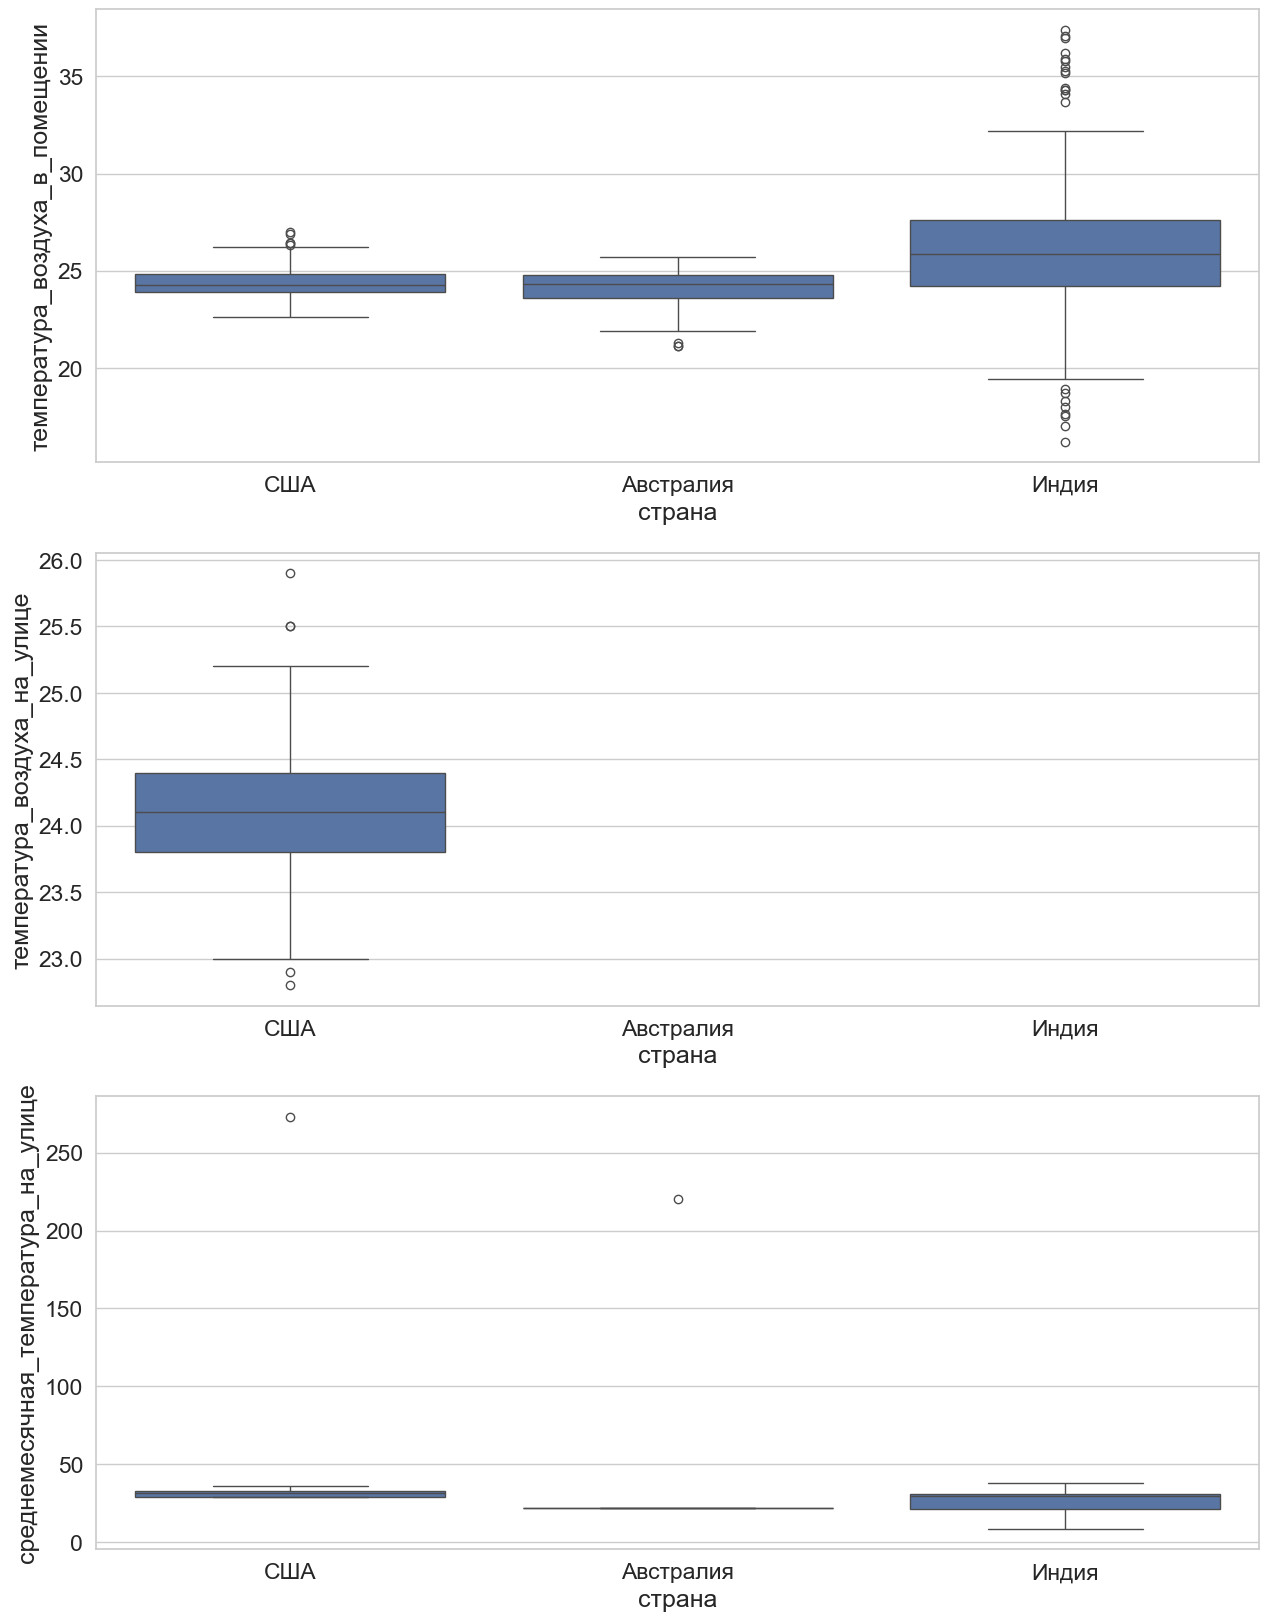

In [14]:
def fix_temperature_room(row):
    if row['страна'] == 'США':
        if row['температура_воздуха_в_помещении'] > 40:
            return row['температура_воздуха_в_помещении'] - 50
    return row['температура_воздуха_в_помещении']

df['температура_воздуха_в_помещении'] = df.apply(fix_temperature_room, axis=1)

def fix_temperature_outside_month(row):
    if row['страна'] == 'США':
        if row['среднемесячная_температура_на_улице'] > 40:
            return row['среднемесячная_температура_на_улице'] - 55
    return row['среднемесячная_температура_на_улице']

df['среднемесячная_температура_на_улице'] = df.apply(fix_temperature_outside_month, axis=1)

fig, ax = plt.subplots(3, 1)
fig.set_figwidth(15)
fig.set_figheight(20)
for i, col in enumerate(temperature_cols):
    sns.boxplot(data=df, x='страна', y=col, ax=ax[i])

C:\Users\Арсений\AppData\Local\Temp\ipykernel_19440\1829793154.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  season_idx = season.index(row[1])
C:\Users\Арсений\AppData\Local\Temp\ipykernel_19440\1829793154.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if lower_bound[season_idx] <= row[col_idx] <= upper_bound[season_idx]:
C:\Users\Арсений\AppData\Local\Temp\ipykernel_19440\1829793154.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser

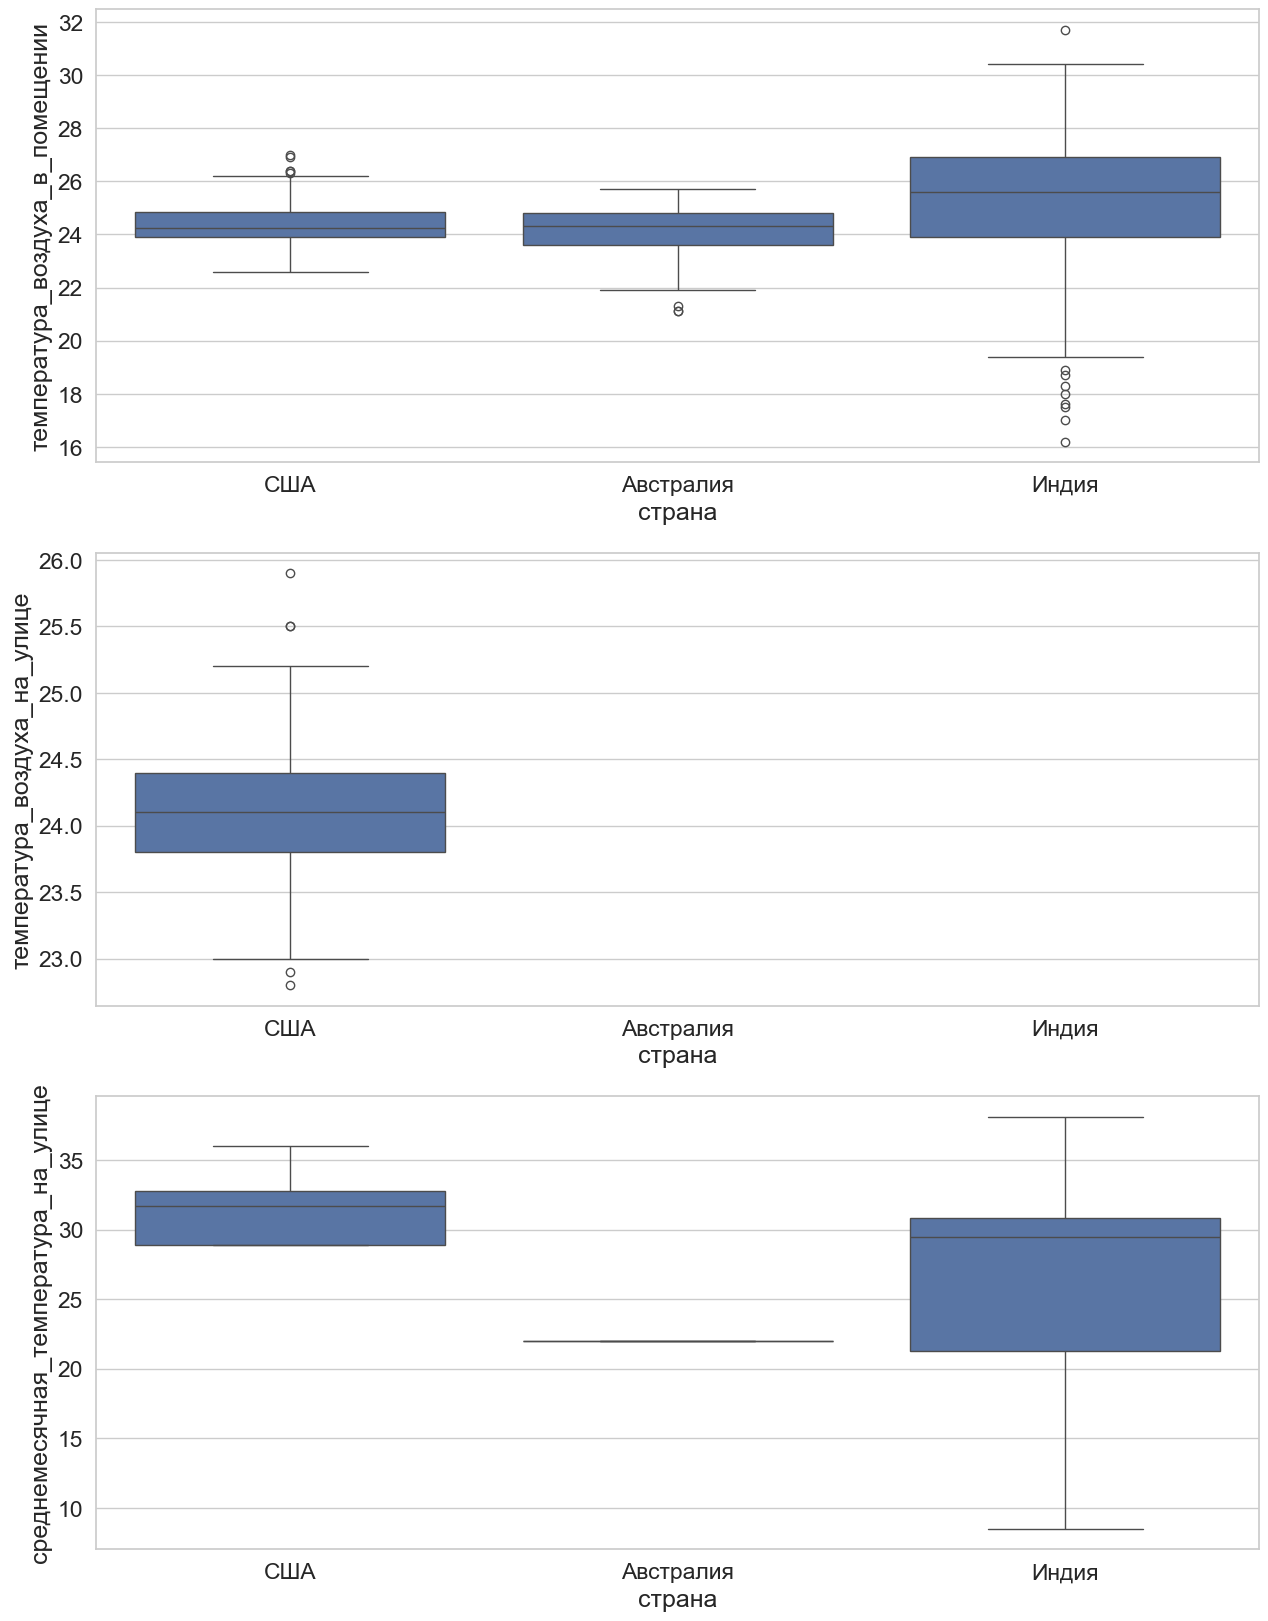

In [15]:
def chnge_temperature(row, c):
    season = ['Лето', 'Зима', 'Осень', 'Весна']
    season_idx = season.index(row[1])
    col_idx = list(row.index).index(c)
    if lower_bound[season_idx] <= row[col_idx] <= upper_bound[season_idx]:
        return row[col_idx]
    return None



for col in temperature_cols:
    Q1 = [
        df[df['время_года'] == 'Лето'][col].quantile(0.25),
        df[df['время_года'] == 'Зима'][col].quantile(0.25),
        df[df['время_года'] == 'Осень'][col].quantile(0.25),
        df[df['время_года'] == 'Весна'][col].quantile(0.25),
    ]
    Q3 = [
        df[df['время_года'] == 'Лето'][col].quantile(0.75),
        df[df['время_года'] == 'Зима'][col].quantile(0.75),
        df[df['время_года'] == 'Осень'][col].quantile(0.75),
        df[df['время_года'] == 'Весна'][col].quantile(0.75),
    ]
    IQR = [
        Q3[0] - Q1[0],
        Q3[1] - Q1[1],
        Q3[2] - Q1[2],
        Q3[3] - Q1[3],
    ]
    lower_bound = [
        Q1[0] - 3 * IQR[0],
        Q1[1] - 3 * IQR[1],
        Q1[2] - 3 * IQR[2],
        Q1[3] - 3 * IQR[3]
    ]
    upper_bound = [
        Q3[0] + 3 * IQR[0],
        Q3[1] + 3 * IQR[1],
        Q3[2] + 3 * IQR[2],
        Q3[3] + 3 * IQR[3],
    ]
    df[col] = df.apply(chnge_temperature, axis=1, c=col)

fig, ax = plt.subplots(3, 1)
fig.set_figwidth(15)
fig.set_figheight(20)
for i, col in enumerate(temperature_cols):
    sns.boxplot(data=df, x='страна', y=col, ax=ax[i])

Индия выглядит подозрительно из-за температуры меньше 15 градусов, однако это зима, поэтому все нормально.

In [16]:
df[(df['страна'] == 'Индия') & (df['среднемесячная_температура_на_улице'] < 15)]['время_года'].value_counts()

время_года
Зима    14
Name: count, dtype: int64

Посмотрим количество пропусков во всех столбцах

In [17]:
df.isna().sum()

год                                              0
время_года                                       0
климат                                           0
город                                            0
страна                                           0
способ_охлаждения                                0
способ_обогрева                                262
возраст                                         71
пол                                             72
ощущение_температуры                             0
ощущение_температуры_(bool)                      0
предпочтительное_изменение_температуры           0
ощущение_движения_воздуха_(bool)               286
предпочтительное_изменение_движения_воздуха      0
оценка_комфорта                                269
утепление                                        0
температура_воздуха_в_помещении                 22
температура_воздуха_на_улице                   412
rh                                               0
скорость_воздуха               

## Обработка дубликатов (удаляем) (task4)

In [18]:
print(df.duplicated().value_counts())
df = df.drop_duplicates()

False    482
True       2
Name: count, dtype: int64


## Заполнение пропусков
Числовые пропуски заполняем сейчас, поскольку их довольно мало. Категориальные пропуски не трогаем до тех пор, пока не начнем с ними работать.

In [19]:
'количество строк, которые имеют пропуски:', len(df[df['возраст'].isna()])

('количество строк, которые имеют пропуски:', 69)

#### Возраст

In [20]:
countries = df.groupby('страна')

In [21]:
def fillna_age(row):
    if pd.isnull(row.loc['возраст']):
        return age_median[row.loc['страна']]
    return row.loc['возраст']


age_median = countries['возраст'].median()
df['возраст'] = df.apply(fillna_age, axis=1)

#### Скорость воздуха

In [22]:
wind_velocity_median = df['скорость_воздуха'].median()
df['скорость_воздуха'] = df['скорость_воздуха'].apply(lambda x: wind_velocity_median if x is None else x)

#### Температура воздуха в помещении

In [23]:
groups = df.groupby(['год', 'время_года', 'город'])['температура_воздуха_в_помещении'].median()

def fix_skips_temp_inside(row):
    if pd.isna(row['температура_воздуха_в_помещении']):
        return groups[row['год'], row['время_года'], row['город']]
    return row['температура_воздуха_в_помещении']

df['температура_воздуха_в_помещении'] = df.apply(fix_skips_temp_inside, axis=1)

#### Среднемесячная температура на улице

In [24]:
temperature_groups = df.groupby(['город', 'год', 'время_года'])['среднемесячная_температура_на_улице'].median()
print(temperature_groups)

temperature_groups['Хайдарабад', 2012, 'Осень'] = (
    temperature_groups['Хайдарабад', 2012, 'Лето'] + temperature_groups['Хайдарабад', 2012, 'Зима']
) / 2

город       год     время_года
Ахмедабад   2012.0  Зима          21.3
                    Лето          29.5
Бангалор    2012.0  Зима          29.9
                    Лето          30.8
Дели        2012.0  Зима          15.5
                    Лето          30.9
Сидней      2010.0  Лето          22.0
Техас       2011.0  Лето          31.7
Хайдарабад  2012.0  Весна         31.5
                    Зима          21.6
                    Лето          27.0
                    Осень          NaN
Ченнай      2012.0  Весна         30.4
                    Зима          30.8
                    Лето          38.1
                    Осень         29.7
Шимла       2012.0  Зима           8.5
                    Лето          18.5
Name: среднемесячная_температура_на_улице, dtype: float64


In [25]:
def fillna_age(row):
    if pd.isnull(row['среднемесячная_температура_на_улице']):
        return temperature_groups[row['город'], row['год'], row['время_года']]
    return row['среднемесячная_температура_на_улице']


df['среднемесячная_температура_на_улице'] = df.apply(fillna_age, axis=1)

# Проведение расчётов и исследований

## Создание категориального стоблца кол-ва рекламаций (task6)

In [26]:
df['количество_рекламаций_кат'] = ['мало' if i <= 1 else ('средне' if i == 2 else 'много') for i in df['количество_рекламаций']]

## Создание категориального столбца по возрастным группам (task 9)

In [27]:
df['возрастная_группа'] = ['молодой возраст' if i <= 44 else ('средний возраст' if 45 <= i <= 59 else 'пожилой возраст') for i in df['возраст']]

## Расчёт средней комфортной температуры в зависимости от возрастной категории (task7)

In [28]:
df[df['ощущение_температуры_(bool)'] == 1].groupby(['возрастная_группа'])['температура_воздуха_в_помещении'].mean()

возрастная_группа
молодой возраст    24.907930
пожилой возраст    25.400000
средний возраст    23.946875
Name: температура_воздуха_в_помещении, dtype: float64

## Средний возраст респондентов по полу и стране (task 8)

По полу:

In [29]:
df.groupby('пол')['возраст'].mean()

пол
Женский    41.923077
Мужской    39.566929
Name: возраст, dtype: float64


По стране:

In [30]:
df.groupby('страна')['возраст'].mean()

страна
Австралия    44.292929
Индия        36.886792
США          36.208333
Name: возраст, dtype: float64

In [31]:
print(df.groupby(['страна', 'пол'])['возраст'].mean())

страна     пол    
Австралия  Женский    46.348315
           Мужской    42.614679
Индия      Женский    36.044776
           Мужской    37.275862
Name: возраст, dtype: float64


## Медианное значение влажности и температуры для каждого типа охлаждения (task 10)

In [32]:
df.groupby('способ_охлаждения')[['температура_воздуха_в_помещении', 'rh']].median()

,температура_воздуха_в_помещении,rh
способ_охлаждения,,
Вентиляция,23.95,53.5
Кондиционирование,24.60,54.1


## Сводная таблица с данными, сгрупированными по стране, полу, возрастной группе(Task 11)

In [33]:
print(df.groupby(['страна', 'пол', 'возрастная_группа'])[['температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh']].mean())

                                     температура_воздуха_в_помещении  \
страна    пол     возрастная_группа                                    
Австралия Женский молодой возраст                          23.840000   
                  пожилой возраст                          24.900000   
                  средний возраст                          24.112500   
          Мужской молодой возраст                          24.146667   
                  пожилой возраст                          24.733333   
                  средний возраст                          24.044262   
Индия     Женский молодой возраст                          25.820192   
                  средний возраст                          23.110000   
          Мужской молодой возраст                          25.685500   
                  пожилой возраст                          29.300000   
                  средний возраст                          24.002273   

                                     температура_воздуха_на_ули

## Стандартная комфортная относительная влажность в помещениях (task 13)
- Согласно [СанПиН 2.2.4.548—96](https://kpfu.ru/portal/docs/F_979595184/SanPiN.2.2.4.548_96.o.mikroklimate.pdf) оптимальная влажность в рабочих помещениях в теплое и холодное время года должна составлять от $40\% - 60 \%$.
- Однако, согласно Управлению по охране труда США (Occupational Safety and Health Administration, OSHA) оптимальная влажность должна лежать в диапазоне от $20\% - 60\%$. [Ссылка на положение](https://www.osha.gov/laws-regs/standardinterpretations/2003-02-24).

Тем не менее, диапазон от $40$ до $60$ является более щадящим, что подтверждается приведенной ниже диаграммой. Поэтому в рамках нашего исследования мы будем опираться на него.
![](https://cndarcdn.scdn3.secure.raxcdn.com/m/0/diagramma-scofild-sterling-rus-01-1.jpg) [Страница с исследованиями в защиту диапазона от 40 до 60](https://40to60rh.com/)

C:\Users\Арсений\AppData\Local\Temp\ipykernel_19440\1521937502.py:10: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['rh_кат']).plot.pie()


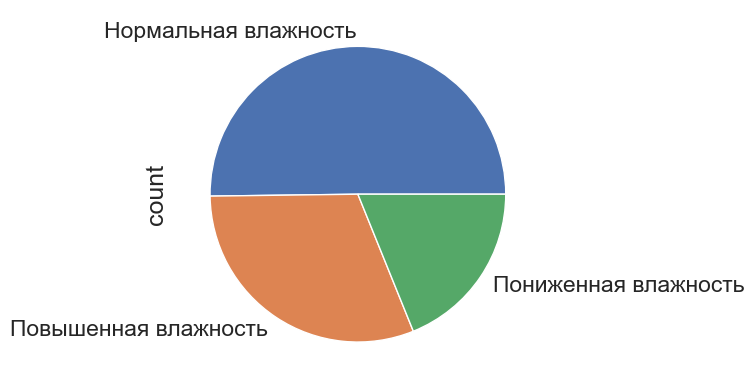

In [34]:
def rh2cat(rh):
    if 40 <= rh <= 60:
        return "Нормальная влажность"
    if rh < 40:
        return "Пониженная влажность"
    return "Повышенная влажность"

df['rh_кат'] = df['rh'].apply(rh2cat)

pd.value_counts(df['rh_кат']).plot.pie()
plt.show()

## Корреляция между параметрами (task14)

In [35]:
# Рассматриваем cущественные корреляции Номинальная-Номаинальная 

# чтобы исследовать корреляцию графически
def show_pie_charts(_col1, _col2):
    global df
    _columns = sorted(df[_col1].dropna().unique())
    _colors = ['green', 'blue', 'orange', 'pink', 'magenta', 'purple', 'red']
    _all_possible_values = df[_col2].unique()

    fig, ax = plt.subplots(len(_columns), 1)
    fig.set_figheight(15)
    fig.set_figwidth(10)
    fig.tight_layout(h_pad=0)

    for _ind, _col in enumerate(_columns):
        _vals = df[df[_col1] == _col][_col2].value_counts(dropna=True)
        wedges, _ = ax[_ind].pie(_vals, colors=_colors)
        ax[_ind].set_title(_col2)
        ax[_ind].legend(wedges, _all_possible_values,
                        title=_col1 + ' = ' + str(_col),
                        loc="center left",
                        bbox_to_anchor=(1, 0, 0.5, 1))

for col1, col2 in itertools.combinations(list(df.columns), 2):
    if col1 in categorial and col2 in categorial:
        if col1 == col2:
            continue

        table = pd.crosstab(df[col1], df[col2])
        if len(table) == 0:
            continue
        
        res = stats.chi2_contingency(table)
        if res[1] < 0.05:
            n = table.sum().sum()
            phi2 = res[0] / n
            kramer = np.sqrt(phi2 / (min(table.shape) - 1))
            if kramer > 0.5:
                print(col1, col2, "  K=", kramer, "  p=", res[1])

год климат   K= 0.7071067811865476   p= 5.109130746665515e-99
год город   K= 1.0   p= 8.249698737851307e-197
год страна   K= 0.9999999999999999   p= 2.259471425529061e-207
климат город   K= 1.0   p= 0.0
климат страна   K= 0.7071067811865475   p= 5.109130746665662e-99
город страна   K= 0.9999999999999999   p= 8.249698737852247e-197
способ_охлаждения отопление   K= 0.8852745960730183   p= 3.589394311695889e-15
ощущение_температуры_(bool) предпочтительное_изменение_температуры   K= 0.5206045559803226   p= 4.2928622573762964e-29
ощущение_температуры_(bool) ощущение_движения_воздуха_(bool)   K= 0.6167399054321971   p= 4.017292262600697e-18
предпочтительное_изменение_температуры ощущение_движения_воздуха_(bool)   K= 0.6415817479010723   p= 2.0046007006970044e-18
ощущение_движения_воздуха_(bool) предпочтительное_изменение_движения_воздуха   K= 0.9101818702019218   p= 2.4070229662646145e-36
занавески вентилятор   K= 0.9722007722007722   p= 1.5919561128165016e-16


- корреляции год - <что-то> являются особенностью данных (за 2010 собраны данные за один город, за 2011 за другой)
- климат - год, климат - страна: корреляции очевидны (города не перемещаются из одной климатической зоны в другую, по крайней мере в рамках наших данных)
- город - способ_охлаждения: эти данные нам также ничего не дают
- страна - <что-то>: особенности данных
- способ_охлаждение - отопление: это не имеет смысла, поскольку корреляция не видна графическим методом и данные содержат много пропусков. Если эти пропуски убрать, то pvalue значительно поднимется
- ощущение_движения_воздуха_(bool) - ощущение_температуры_(bool): видимо если людям нравится как двигается воздух, то им нравится температура
- ощущение_движения_воздуха_(bool) - предпочтительное_изменение_температуры: если людям нравится как движется воздух, то они не хотят менять температуру?
- занавески - вентилятор: наличие занавесок говорит нам о наличии вентрилятора у человека

In [36]:
# Рассматриваем cущественные корреляции Количественная-Номаинальная 
temp_df = df.copy()
temp_df['способ_обогрева'] = temp_df['способ_обогрева'].fillna('нет')


for col1, col2 in itertools.product(list(categorial), list(numerical), repeat=1):
    if col1 == col2:
        continue
        
    if len(temp_df[col1].unique()) <= 2:
        g1 = temp_df[temp_df[col1] == temp_df[col1].unique()[0]][col2]
        g2 = temp_df[temp_df[col1] == temp_df[col1].unique()[1]][col2]

        if stats.shapiro(g1)[1] > 0.05 and stats.shapiro(g2)[1] > 0.05:
            # применяем метод Стьюдента
            res = stats.ttest_ind(g1, g2)
            if res[1] < 0.05:
                print(col1, col2, "  p=", res[1], 'Стьюдента')
        else:
            # применяем метод Манна-Уитни
            res = stats.mannwhitneyu(g1, g2)
            if res[1] < 0.05:
                print(col1, col2, "  p=", res[1], 'Манна-Уитни')
    else:
        groups = []
        for i in temp_df[col1].unique():
            groups.append(temp_df[temp_df[col1] == i][col2])

        flag_normal = True
        for g in groups:
            if len(g) < 3 or stats.shapiro(g)[1] <= 0.05:
                # ненормальное распределение
                # применяем метод Краскела-Уоллиса
                flag_normal = False
                break

        if flag_normal:
            # применяем метод ANOVA
            res = stats.f_oneway(*groups)
            if res[1] < 0.05:
                print(col1, col2, "  p=", res[1], 'ANOVA')
        else:
            # применяем метод Краскела-Уоллиса
            groups = []
            for i in temp_df[col1].unique():
                groups.append(temp_df[temp_df[col1] == i][col2])
    
            res = stats.kruskal(*groups)
            if res[1] < 0.05:
                print(col1, col2, "  p=", res[1], 'Краскела-Уоллиса')

год возраст   p= 2.640064035122042e-14 Краскела-Уоллиса
год температура_воздуха_в_помещении   p= 9.936107660748491e-13 Краскела-Уоллиса
год rh   p= 5.625685108857245e-41 Краскела-Уоллиса
год среднемесячная_температура_на_улице   p= 9.988552410558766e-31 Краскела-Уоллиса
год количество_рекламаций   p= 1.2581926187738393e-14 Краскела-Уоллиса
год утепление   p= 9.086116228428573e-72 Краскела-Уоллиса
год ощущение_температуры   p= 5.070744502746438e-10 Краскела-Уоллиса
предпочтительное_изменение_температуры температура_воздуха_в_помещении   p= 0.00035523428596075915 Краскела-Уоллиса
предпочтительное_изменение_температуры среднемесячная_температура_на_улице   p= 5.8759950421507315e-05 Краскела-Уоллиса
предпочтительное_изменение_температуры количество_рекламаций   p= 1.1041850623825454e-05 Краскела-Уоллиса
предпочтительное_изменение_температуры утепление   p= 0.004958305711016792 Краскела-Уоллиса
предпочтительное_изменение_температуры ощущение_температуры   p= 2.7720948513990005e-18 Краскела-

- способ_обогрева - среднемесячная_температура_на_улице: очевидно, что от среднемесячной теспературы будет зависеть, стоит ли у людей в доме отопление или нет.

<Axes: xlabel='способ_обогрева', ylabel='среднемесячная_температура_на_улице'>

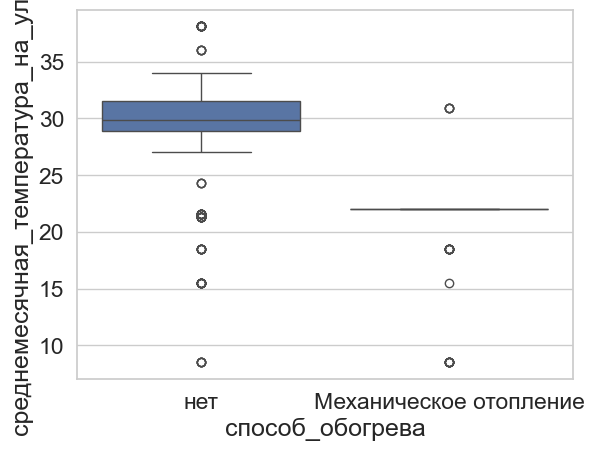

In [37]:
sns.boxplot(data=temp_df, x='способ_обогрева', y='среднемесячная_температура_на_улице')

<Axes: xlabel='пол', ylabel='рост'>

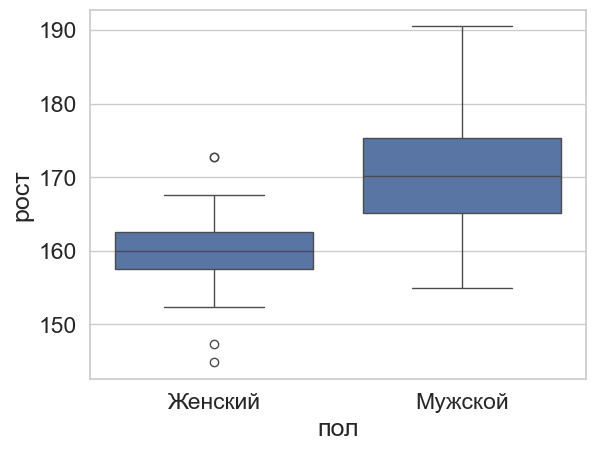

In [38]:
sns.boxplot(data=temp_df, x='пол', y='рост')

- пол - рост
- климат - утепление: в жарких краях люди не вынуждены носить много теплой одежды
- страна - среднемесячная_температура_на_улице: погода (температура) циклична

In [39]:
# Рассматриваем cущественные корреляции Количественная-Количественная

for col1, col2 in itertools.product(list(numerical), list(numerical), repeat=1):
    if col1 == col2:
        continue
    
    temp_df = df[[col1, col2]].copy().dropna()

    if (len(temp_df[col1]) > 3 and len(temp_df[col2] > 3)) and stats.shapiro(temp_df[col1])[1] > 0.05 and stats.shapiro(temp_df[col2])[1] > 0.05:
        # применяем метод Пирсона
        res = stats.pearsonr(temp_df[col1], temp_df[col2])
        if res[1] < 0.05 and abs(res[0]) > 0.3:
            print(col1, col2, "  p=", res[1], " r=", res[0], 'Пирсона')
    else:
        # применяем метод Спирмена
        res = stats.spearmanr(temp_df[col1], temp_df[col2])
        if res[1] < 0.05 and abs(res[0]) > 0.3:
            print(col1, col2, "  p=", res[1], " r=", res[0], 'Спирмена')

возраст среднемесячная_температура_на_улице   p= 1.2477401023875298e-11  r= -0.30211805122167357 Спирмена
температура_воздуха_в_помещении температура_воздуха_на_улице   p= 6.51106808320348e-12  r= 0.7018358196427039 Спирмена
температура_воздуха_в_помещении среднемесячная_температура_на_улице   p= 1.782538830428729e-15  r= 0.35164386936600295 Спирмена
температура_воздуха_на_улице температура_воздуха_в_помещении   p= 6.511068083203432e-12  r= 0.701835819642704 Спирмена
температура_воздуха_на_улице rh   p= 0.0003220180302585918  r= -0.4121090281110435 Спирмена
температура_воздуха_на_улице среднемесячная_температура_на_улице   p= 6.68769431377363e-07  r= 0.5468780973076165 Спирмена
rh температура_воздуха_на_улице   p= 0.0003220180302585918  r= -0.4121090281110435 Спирмена
rh утепление   p= 1.1000607794607387e-19  r= -0.39739736393884445 Спирмена
скорость_воздуха среднемесячная_температура_на_улице   p= 1.102856244334549e-31  r= 0.5033469507274467 Спирмена
рост вес   p= 1.6470326341697903e-

- температура_воздуха_в_помещении - температура_воздуха_на_улице: логично
- рост - вес: хорошего человека должно быть много

# Проверка гипотез

## Влияет ли способ охлаждения на оценку комфорта (task 15)

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [40]:
df['способ_охлаждения'].value_counts()

способ_охлаждения
Кондиционирование    349
Вентиляция           133
Name: count, dtype: int64

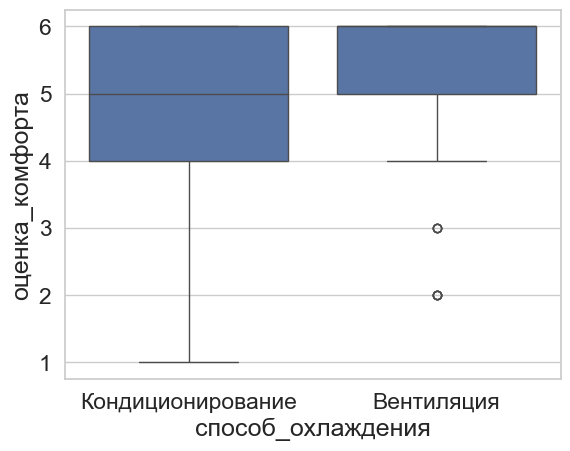

Распрление нормальное?:  False
pvalue = 0.006518902539739624
5.0 6.0


In [41]:
temp_df = df[['способ_охлаждения', 'оценка_комфорта']].copy()
temp_df = temp_df.dropna()

sns.boxplot(x='способ_охлаждения', y='оценка_комфорта', data=temp_df)
plt.show()

# Шкалы разные: способ охлаждения - номинальная (2 уровня), оценка комфорта - количественная
# Проверка как распределена оценка комфорта
g1 = temp_df[temp_df['способ_охлаждения'] == 'Вентиляция']['оценка_комфорта']
g2 = temp_df[temp_df['способ_охлаждения'] == 'Кондиционирование']['оценка_комфорта']

print("Распрление нормальное?: ", stats.shapiro(g1)[1] > 0.05 and stats.shapiro(g2)[1] > 0.05)

# Распределение ненормальное, поэтому применяем критерий Манна-Уитни

print("pvalue =", stats.mannwhitneyu(g1, g2)[1])

print(g2.median(), g1.median())

pvalue получилось менее 0.05, значит мы можем отвергнуть нулевую гипотезу о том, что эффекта нет. **Тогда мы принимаем альтернативную гипотезу, что способ охлаждения влияет на оценку комфорта. Причем клиенты больше довольны вентиляцией, чем кондиционированием.**

## Влияние пола на оценку комфорта (task16)

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

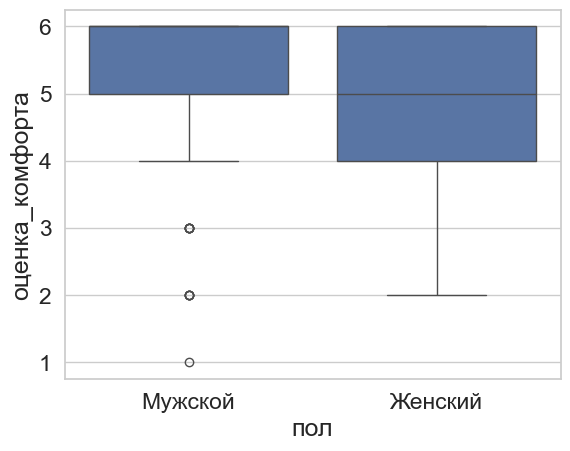

Распрление нормальное?:  False
pvalue = 0.12111267889388343
Если считать что кто оценка_комфорта это также номинальная шкала    K= 0.20188828123633423   p= 0.3232639674687969


In [42]:
temp_df = df[['пол', 'оценка_комфорта']].copy()
temp_df = temp_df.dropna()

sns.boxplot(x='пол', y='оценка_комфорта', data=temp_df)
plt.show()

# Шкалы разные: пол - номинальная (2 уровня), оценка комфорта - количественная
# Проверим, как распределена оценка комфорта
g1 = temp_df[temp_df['пол'] == 'Мужской']['оценка_комфорта']
g2 = temp_df[temp_df['пол'] == 'Женский']['оценка_комфорта']

print("Распрление нормальное?: ", stats.shapiro(g1)[1] > 0.05 and stats.shapiro(g2)[1] > 0.05)

# Распределение ненормальное, поэтому применяем метод Манна-Уитни

print("pvalue =", stats.mannwhitneyu(g1, g2)[1])

# Если оценка_комфорта это номинальная шкала, то нужно применить хи-квадрат чтобы проверить корреляцию

table = pd.crosstab(df['пол'], df['оценка_комфорта'])

res = stats.chi2_contingency(table)

n = table.sum().sum()
phi2 = res[0] / n
kramer = np.sqrt(phi2 / (min(table.shape) - 1))
print("Если считать что кто оценка_комфорта это также номинальная шкала", "   K=", kramer, "  p=", res[1])

pvalue получилось более 0.05, значит мы не можем отвергнуть нулевую гипотезу о том, что фактор и отклик как-либо зависимы. То есть **подтвердить влияние пола на оценку комфорта невозможно при наших данных.**

## Влияет ли возрастная группа на оценку комфорта (task17)
- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

<Axes: xlabel='возрастная_группа', ylabel='оценка_комфорта'>

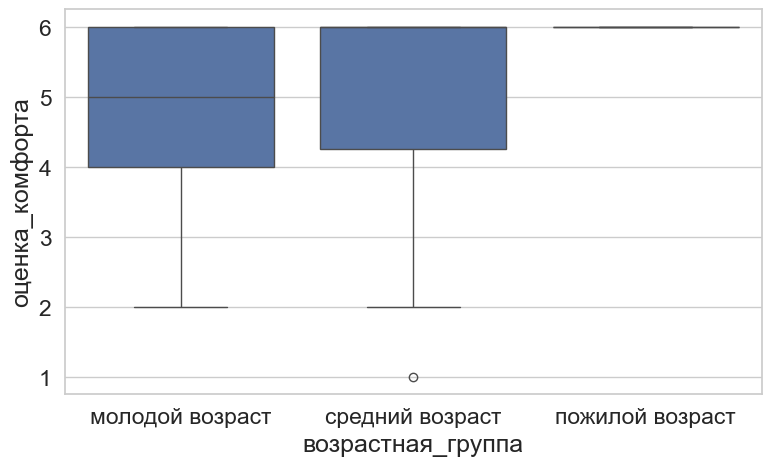

In [43]:
fig, ax = plt.subplots(figsize=(9,5))
sns.boxplot(df, x='возрастная_группа', y='оценка_комфорта', ax=ax)

Поскольку `возрастная_группа` представленна в виде категориальной шкалы, а `оценка_комфорта` в количественной, то будем использовать критерий Красскела-Уоллеса или ANOVA. Для это определим нормальность распределения в столбце `оценка_комфорта` 

Распределение ненормальное, используем критерий Красскела-Уоллеса


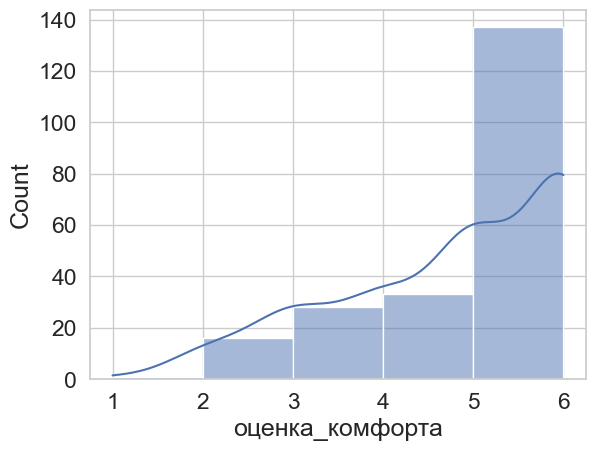

In [44]:
sns.histplot(df, x='оценка_комфорта', kde=True, bins=5)

gp = df.groupby('возрастная_группа')['оценка_комфорта']
groups = [v for v in gp.groups.values()]

flag_normal = True
for g in groups:
    if len(g) < 3 or stats.shapiro(g)[1] <= 0.05:
        # ненормальное распределение
        # применяем метод Краскела-Уоллиса
        flag_normal = False
        break

if flag_normal:
    print('Распределение \033[1mнормальнное\033[0m, исппользуем ANOVA')
else:
    print('Распределение \033[1mненормальное\033[0m, используем критерий Красскела-Уоллеса')

In [45]:
krus = stats.kruskal(*groups)
krus

KruskalResult(statistic=7.2979402446489985, pvalue=0.026017910250498436)

In [46]:
if krus[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств того, что возрастная группа влияет на оценку комфорта.')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств того, что возрастная группа \033[1mвлияет\033[0m на оценку комфорта.')

Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.
Следовательно, у нас достаточно доказательств того, что возрастная группа влияет на оценку комфорта.


## Взаимосвязь между количеством рекламаций и оценкой комфорта (task18)
- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

корелляция и pvalue:  SignificanceResult(statistic=-0.5698346757909493, pvalue=6.576564545436688e-20)


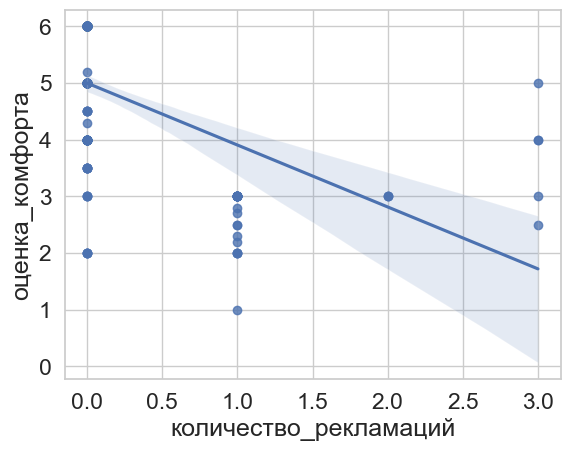

In [47]:
temp_df = df[['оценка_комфорта', 'количество_рекламаций']].copy().dropna()

if stats.shapiro(temp_df['оценка_комфорта'])[1] > 0.05 and stats.shapiro(temp_df['количество_рекламаций'])[1] > 0.05:
    # применяем метод Пирсона
    print("корелляция и pvalue: ", stats.pearsonr(temp_df['оценка_комфорта'], temp_df['количество_рекламаций']))
else:
    # применяем метод Спирмена
    print("корелляция и pvalue: ", stats.spearmanr(temp_df['оценка_комфорта'], temp_df['количество_рекламаций']))

sns.regplot(df, x='количество_рекламаций', y='оценка_комфорта')
plt.show()

Корреляция (0.5) не сильная, однако и не нулевая (можно сказать средняя). Pvalue намного меньше 0.05, поэтому мы можем доверять полученной корреляции. ***То есть взаимосвязь есть, однако она не сильная. Чем больше рекламаций, тем хуже оценка комфорта.***

## Проверить гипотезу о том, что средняя оценка комфорта отличается в зависимости от страны (task19)
- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

<Axes: xlabel='страна', ylabel='оценка_комфорта'>

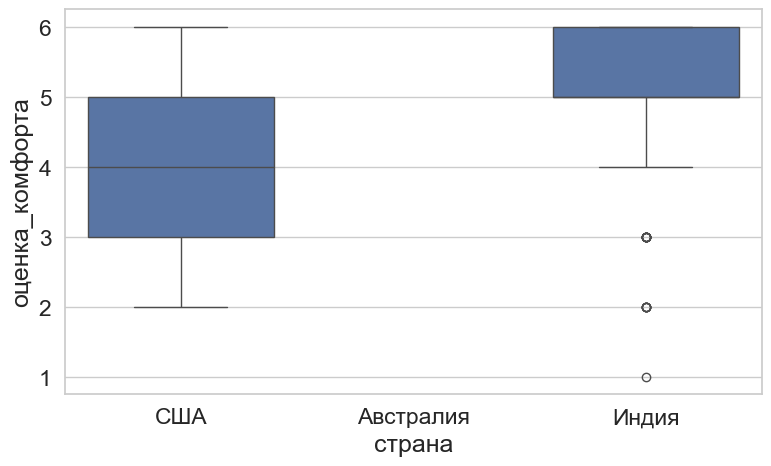

In [48]:
fig, ax = plt.subplots(figsize=(9,5))
sns.boxplot(df, x='страна', y='оценка_комфорта', ax=ax)

По графику не трудно заметить, что средняя оценка у Индии больше чем у США, а у Австралии вообще нет оценок.
Впрочем это можно подтвердить аналитически

In [64]:
temp_df = df[['страна', 'оценка_комфорта']].copy().dropna()

gp = temp_df.groupby('страна')
groups = [v for v in gp.groups.values()]

flag_normal = True
for g in groups:
    if len(g) < 3 or stats.shapiro(g)[1] <= 0.05:
        # ненормальное распределение
        # применяем метод Краскела-Уоллиса
        flag_normal = False
        break

if flag_normal:
    print('Распределение \033[1mнормальнное\033[0m, исппользуем ANOVA')
    temp = stats.f_oneway(*(v for v in gp.groups.values()))
else:
    print('Распределение \033[1mненормальное\033[0m, используем критерий Красскела-Уоллиса')
    temp = stats.kruskal(*(v for v in gp.groups.values()))

print(temp)

if temp[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств того, что средняя оценка комфорта отличается в зависимости от страны.')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств того, что средняя оценка комфорта отличается в зависимости от страны.')

Распределение ненормальное, используем критерий Красскела-Уоллиса
KruskalResult(statistic=142.9999999999999, pvalue=5.878017999154324e-33)
Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.
Следовательно, у нас достаточно доказательств того, что средняя оценка комфорта отличается в зависимости от страны.


Итак, средняя оценка комфортра отличается в зависимости от страны

## Выдвинуть и проверить гипотезу по влиянию разных факторов на оценку комфорта/ощущение температуры/ощущение движения воздуха (task 21)

### Оценка комфорта

**Гипотеза**
> **Фактор Cреднемесячная температура на улице** влияет на **оценку комфорта**  

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [50]:
# Поскольку колонки среднемесячная_температура_на_улице и оценка_комфорта представленны одинаковыми типами
# Так как обе колонки представлены колличественными типами, то будем использовать корреляцию пирсона
temp_df = df[['среднемесячная_температура_на_улице', 'оценка_комфорта']].copy().dropna()

if stats.shapiro(temp_df['среднемесячная_температура_на_улице'])[1] > 0.05 and stats.shapiro(temp_df['оценка_комфорта'])[1] > 0.05:
    # применяем метод Пирсона
    temp = stats.pearsonr(temp_df['среднемесячная_температура_на_улице'], temp_df['оценка_комфорта'])
else:
    # применяем метод Спирмена
    temp = stats.spearmanr(temp_df['среднемесячная_температура_на_улице'], temp_df['оценка_комфорта'])

print(temp)

if temp[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств чтобы сказать, что фактор среднемесячная температура на улице влияют на оценку комфорта.')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств чтобы сказать, что фактор среднемесячная температура на улице \033[1mвлияет\033[0m на оценку комфорта.')
print('Также можно заметить, что показатель кореляции является отрицательным, что означает, что чем ниже температура, тем больше оценка комфорта. Модуль коэфицента корреляции') 
print('приблизительно равен 0.3, что говорит об очень слабой взаимосвязи ')

SignificanceResult(statistic=-0.3078541688312144, pvalue=4.226502210136057e-06)
Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.
Следовательно, у нас достаточно доказательств чтобы сказать, что фактор среднемесячная температура на улице влияет на оценку комфорта.
Также можно заметить, что показатель кореляции является отрицательным, что означает, что чем ниже температура, тем больше оценка комфорта. Модуль коэфицента корреляции
приблизительно равен 0.3, что говорит об очень слабой взаимосвязи 


### Ощущение температуры

**Гипотеза**
> Вес респондента влияет на его ощущение температуры  

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [51]:
# Поскольку колонки среднемесячная_температура_на_улице и ощущение_температуры представленны одинаковыми типами
# Так как обе колонки представлены колличественными типами, то будем использовать корреляцию пирсона
temp_df = df[['вес', 'ощущение_температуры']].copy().dropna()

if stats.shapiro(temp_df['вес'])[1] > 0.05 and stats.shapiro(temp_df['ощущение_температуры'])[1] > 0.05:
    # применяем метод Пирсона
    temp = stats.pearsonr(temp_df['вес'], temp_df['ощущение_температуры'])
else:
    # применяем метод Спирмена
    temp = stats.spearmanr(temp_df['вес'], temp_df['ощущение_температуры'])

print(temp)

if temp[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств того, что вес респондента влияет на ощущение температуры.')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств того, что вес респондента \033[1mвлияет\033[0m на ощущение температуры.')

SignificanceResult(statistic=0.03867716091598628, pvalue=0.5754602847830063)
Поскольку p-значение не меньше 0,05, мы не можем отвергнуть нулевую гипотезу.
Следовательно, у нас нет достаточных доказательств того, что вес респондента влияет на ощущение температуры.


## Влияние разных факторов на оценку комфорта/ощущение температуры/ощущение движения воздуха (task 22)

### Оценка комфорта

**Гипотеза**
> **Категории влажности** влияют на **оценку комфорта**  

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [52]:
# Поскольку колонки rh_кат и оценка_комфорта представленны разными типами
# А в rh_кат более двух уровней, будем использовать ANOVA или критерий Красскела-Уоллиса

temp_df = df[['rh_кат', 'оценка_комфорта']].copy().dropna()

gp = temp_df.groupby('rh_кат')
groups = [v for v in gp.groups.values()]

flag_normal = True
for g in groups:
    if len(g) < 3 or stats.shapiro(g)[1] <= 0.05:
        # ненормальное распределение
        # применяем метод Краскела-Уоллиса
        flag_normal = False
        break

if flag_normal:
    print('Распределение \033[1mнормальнное\033[0m, исппользуем ANOVA')
    temp = stats.f_oneway(*(v for v in gp.groups.values()))
else:
    print('Распределение \033[1mненормальное\033[0m, используем критерий Красскела-Уоллиса')
    temp = stats.kruskal(*(v for v in gp.groups.values()))

print(temp)

if temp[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств того, что категории относительной влажности влияют на оценку комфорта.')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств того, что категории относительной влажности \033[1mвлияет\033[0m на оценку комфорта.')

Распределение ненормальное, используем критерий Красскела-Уоллиса
KruskalResult(statistic=38.52266293274033, pvalue=4.3142969109534216e-09)
Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.
Следовательно, у нас достаточно доказательств того, что категории относительной влажности влияет на оценку комфорта.


### Ощущение температуры

**Гипотеза**
> принадлежность респондента к возрастной группе влияет на его ощущение температуры  

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [53]:
# Поскольку колонки возрастная_группа и ощущение_температуры представленны разными типами
# А в возрастная_группе более двух уровней, будем использовать ANOVA или критерий Красскела-Уоллеса

temp_df = df[['возрастная_группа', 'ощущение_температуры']].copy().dropna()

gp = temp_df.groupby("возрастная_группа")
groups = [v for v in gp.groups.values()]

flag_normal = True
for g in groups:
    if len(g) < 3 or stats.shapiro(g)[1] <= 0.05:
        # ненормальное распределение
        # применяем метод Краскела-Уоллиса
        flag_normal = False
        break

if flag_normal:
    temp = stats.f_oneway(*(v for v in gp.groups.values()))
else:
    temp = stats.kruskal(*(v for v in gp.groups.values()))

print(temp)

if temp[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств того, что принадлежность к возрастной группе влияет на оценку ощущения температуры')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств того, что принадлежность к возрастной группе влияет на оценку ощущения температуры.')

KruskalResult(statistic=7.2979402446489985, pvalue=0.026017910250498436)
Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.
Следовательно, у нас достаточно доказательств того, что принадлежность к возрастной группе влияет на оценку ощущения температуры.


### Ощущение движения воздуха

**Гипотеза**
> Пренадлежность респондента к возрастной групп влияет на его ощущения движения воздуха

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [54]:
temp_df = df[['ощущение_движения_воздуха_(bool)', 'возрастная_группа']].copy().dropna()

crosstab = pd.crosstab(temp_df['ощущение_движения_воздуха_(bool)'], temp_df['возрастная_группа'])
chi2 = stats.chi2_contingency(crosstab)[0]
n = crosstab.sum().sum()
phi2 = chi2 / n
kramer = np.sqrt(phi2 / (min(crosstab.shape) - 1))

print("k =", kramer)

k = 0.17909519344181102


Корреляция есть, но она очень слабая. Поэтому нельзя отвергнуть нулевую гипотезу.
Следовательно, на основаниии имеющихся данных ***нельзя сказать, что принадлежность респондента к возрастной групп влияет на его ощущения движения воздуха***

## Какая скорость воздуха будет комфортной, и есть ли корреляция оценки воздуха с его реальной скоростью(task20)

<Axes: xlabel='ощущение_движения_воздуха_(bool)', ylabel='скорость_воздуха'>

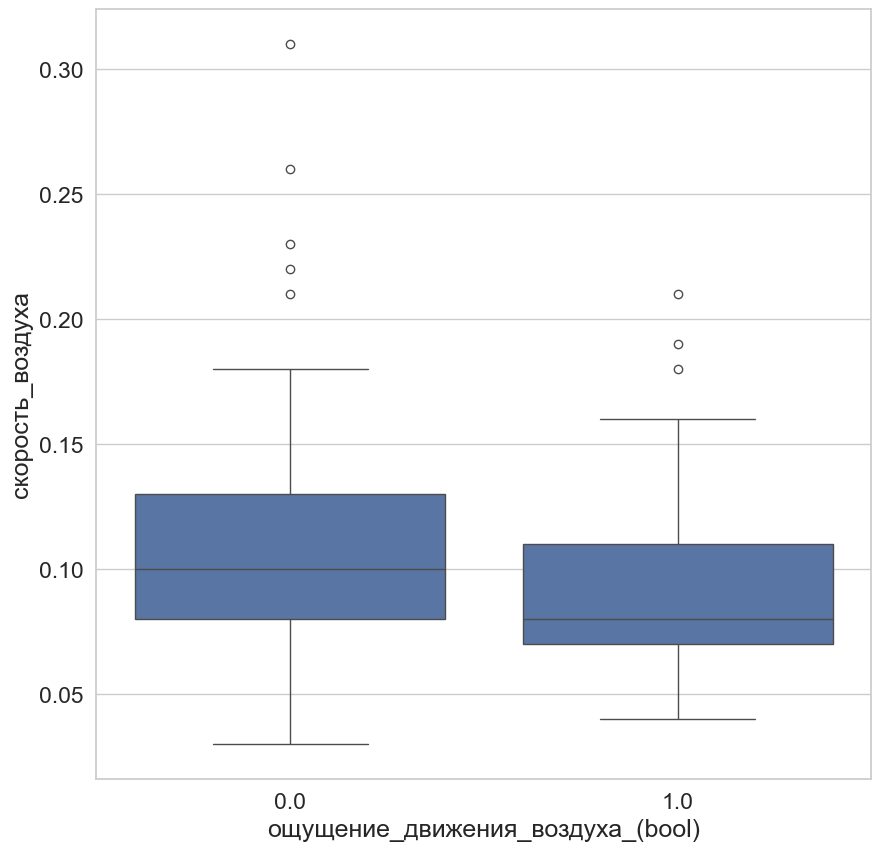

In [55]:
temp_df = df[['ощущение_движения_воздуха_(bool)', 'скорость_воздуха']].copy().dropna()

plt.figure(figsize=(10,10))
sns.boxplot(data=temp_df, x='ощущение_движения_воздуха_(bool)', y='скорость_воздуха')

In [56]:
g1 = temp_df[temp_df['ощущение_движения_воздуха_(bool)'] == 1]['скорость_воздуха']
g2 = temp_df[temp_df['ощущение_движения_воздуха_(bool)'] == 0]['скорость_воздуха']

if stats.shapiro(g1)[1] > 0.05 and stats.shapiro(g2)[1] > 0.05:
    print('распределение нормальное')
else:
    print('распределение ненормальное')

# Распределение ненормальное поэтому используем метод Манна-Уитни, чтобы исследовать корреляцию

_, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
print('pvalue = ', p)

распределение ненормальное
pvalue =  0.004529414866412486


pvalue меньше 0.05, поэтому мы отвергаем нулевую гипотезу и принимаем альтернативную, что ***распределния не равны и имеют статистически значимые отличия*** </br> Также по графику обратим внимание на медианы и распределение в целом: ***чем меньше скорость воздуха, тем больше шанс, что респондента устраивает скорость воздуха в помещении***

<Axes: xlabel='оценка_комфорта', ylabel='скорость_воздуха'>

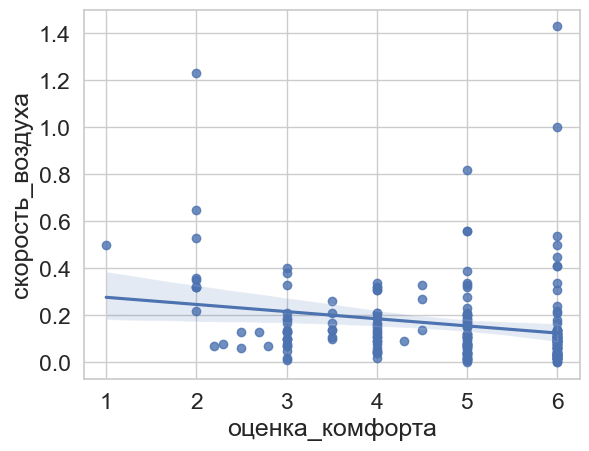

In [57]:
temp_df = df[['оценка_комфорта', 'скорость_воздуха']].copy().dropna()

sns.regplot(data=temp_df, x='оценка_комфорта', y='скорость_воздуха')

In [58]:
if stats.shapiro(temp_df['скорость_воздуха'])[1] > 0.05 and stats.shapiro(temp_df['оценка_комфорта'])[1] > 0.05:
    print('распределение нормальное')
else:
    print('распределение ненормальное')

# Распределение ненормальное поэтому используем корреляцию Спирмена

k, p = stats.spearmanr(temp_df['скорость_воздуха'], temp_df['оценка_комфорта'])
print('k=', k, '  pvalue = ', p)

распределение ненормальное
k= -0.2902005376576328   pvalue =  2.4341269002141024e-05


Pvalue меньше 0.05, то есть эффект есть, однако значимой корреляции между скоростью воздуха и оценкой комфорта нет (0.29 не сильная корреляция), то есть: ***скорость воздуха влияет на оценку комфорта, но не сильно***

# Регрессионное моделирование
Чтобы построить рабочую модель для предсказания температуры, необходимо выявить все факторы, которые могут влиять на температуру, то есть найти корреляции между факторами. </br>
Нужные факторы можно выбрать, основываясь на подтвержденные гипотезы и сильные корреляции выше. </br></br>
Для построения модели будем использовать такие факторы как: **страна, климат, время года, город**, поскольку эти факторы имеют статистически значимые корреляции с температурой воздуха в помещении(pvalue меньше 0.05) и эти факторы не будут являться утечкой, так как эти данные можно легко найти при необходимости. </br>

In [59]:
temp_df = df[['город', 'время_года', 'способ_охлаждения', 'среднемесячная_температура_на_улице', 'температура_воздуха_в_помещении']].copy()

temp_df

,город,время_года,способ_охлаждения,среднемесячная_температура_на_улице,температура_воздуха_в_помещении
0,Техас,Лето,Кондиционирование,28.9,22.90
1,Техас,Лето,Кондиционирование,29.0,24.80
2,Техас,Лето,Кондиционирование,32.8,25.60
3,Техас,Лето,Кондиционирование,28.9,24.20
4,Техас,Лето,Кондиционирование,32.8,23.80
...,...,...,...,...,...
477,Хайдарабад,Зима,Вентиляция,21.6,29.50
478,Ченнай,Лето,Кондиционирование,38.1,28.80
479,Дели,Лето,Вентиляция,30.9,23.95
480,Ченнай,Зима,Кондиционирование,30.8,26.50


MAE: 0.9881538995947848
MSE: 1.8338720928669507
RMSE: 1.3542053363013125
R2: 0.4934139025043013


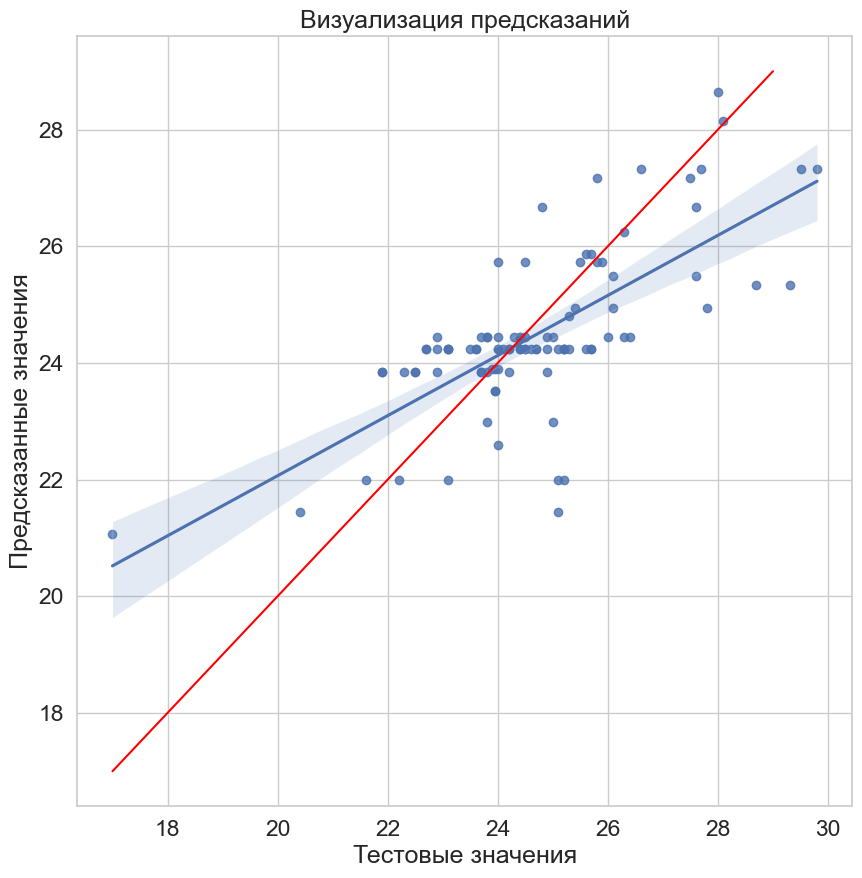

In [60]:
# Тестовая и тренировочные выборки
X_train, X_test, y_train, y_test = train_test_split(temp_df[['город', 'время_года', 'способ_охлаждения', 'среднемесячная_температура_на_улице', 'способ_охлаждения']], temp_df['температура_воздуха_в_помещении'], test_size=0.2, random_state=42)

# Кодирование категориальных признаков
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train[['город', 'время_года', 'способ_охлаждения']])
X_train = encoder.transform(X_train[['город', 'время_года', 'способ_охлаждения']])
X_test = encoder.transform(X_test[['город', 'время_года', 'способ_охлаждения']])

# Обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание
y_pred = model.predict(X_test)

# Оценка модели
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))

# Визуализация

plt.figure(figsize=(10,10))
sns.regplot(x=y_test, y=y_pred)
plt.plot(np.arange(17, 30), np.arange(17, 30), color='red')
plt.xlabel('Тестовые значения')
plt.ylabel('Предсказанные значения')
plt.title('Визуализация предсказаний')
plt.show()

# Выводы

In [61]:
df['климат_способ'] = df['климат'] + '_' + df['способ_охлаждения']

In [62]:
temp_df = df[['климат_способ', 'оценка_комфорта']].copy().dropna()
# --------------------------------------------------------------------------------------------------------------------------

if stats.shapiro(temp_df.оценка_комфорта)[1] >= 0.5:
    temp = stats.f_oneway(*(v for v in gp.groups.values()))
else:
    temp = stats.kruskal(*(v for v in gp.groups.values()))

print(temp)

KruskalResult(statistic=7.2979402446489985, pvalue=0.026017910250498436)


<Axes: xlabel='оценка_комфорта', ylabel='климат_способ'>

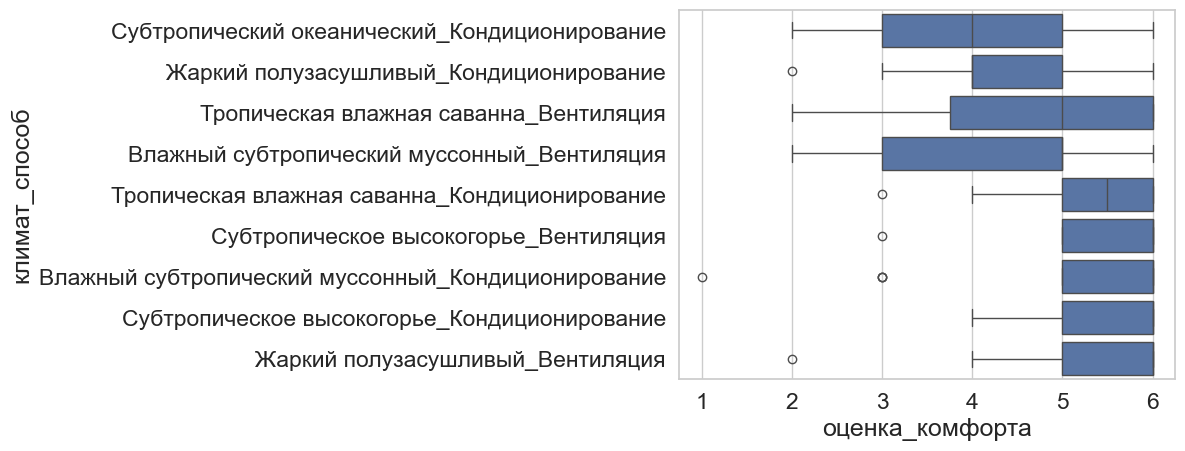

In [63]:
sns.boxplot(temp_df, x='оценка_комфорта', y='климат_способ', order=sorted(temp_df['климат_способ'].unique(), key=lambda x: temp_df[temp_df['климат_способ'] == x]['оценка_комфорта'].median()))